In [17]:
import cv2
import numpy as np
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt

DATASET_ROOT = Path("dataset/writer1")  # ใช้โฟลเดอร์ใหม่ที่เตรียมไว้
IMG_SIZE = 32                          # 32x32 pixels
K = 3                                  # k-NN
TRAIN_SPLIT = 0.8                      # 80% train, 20% test
SEED = 42

# auto list labels from folder names (เช่น ['A','B','C',...])
LABEL_NAMES = sorted([p.name for p in DATASET_ROOT.iterdir() if p.is_dir()])
print("Labels:", LABEL_NAMES)

Labels: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


In [18]:
# helper function to show images
def show(img, title="", cmap=None, size=(4,4)):
    plt.figure(figsize=size)
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap if cmap else "gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

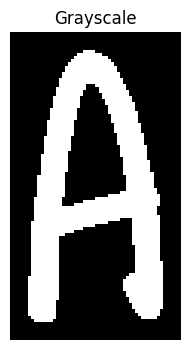

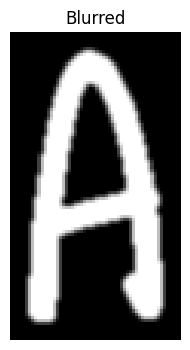

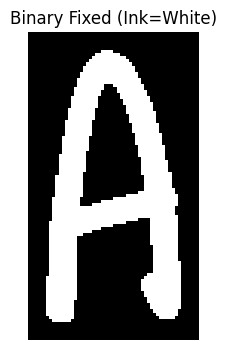

In [19]:
# read one sample image
img = cv2.imread("dataset/writer1/A/A_001.png")

# 1) Grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show(gray, title="Grayscale")

# 2) Gaussian Blur
blur = cv2.GaussianBlur(gray, (3,3), 0)
show(blur, title="Blurred")

# 3) Otsu Threshold (Ink = White)
_, bw = cv2.threshold(
    blur, 0, 255,
    cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
)
# invert again so ink = white, background = black
bw_fixed = cv2.bitwise_not(bw)
show(bw_fixed, title="Binary Fixed (Ink=White)")

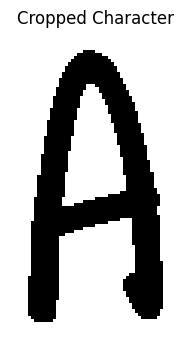

In [20]:
# หา bounding box ของตัวอักษร
# หา pixel ที่เป็นหมึกจริง ๆ (ขาว)
ys, xs = np.where(bw > 0)

y_min, y_max = ys.min(), ys.max()
x_min, x_max = xs.min(), xs.max()

cropped = bw[y_min:y_max+1, x_min:x_max+1]

show(cropped, title="Cropped Character")

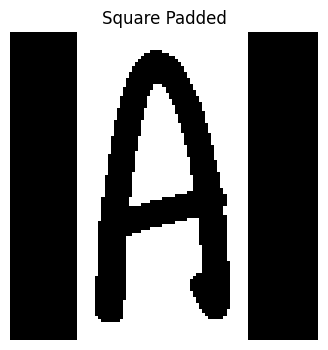

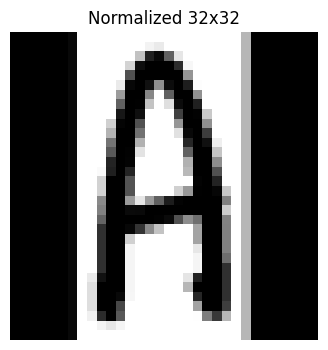

In [21]:
# 1) ทำให้ภาพเป็นสี่เหลี่ยมจัตุรัสก่อน resize
h2, w2 = cropped.shape
side = max(h2, w2)

square = np.zeros((side, side), dtype=np.uint8)

y_offset = (side - h2) // 2
x_offset = (side - w2) // 2

square[y_offset:y_offset+h2, x_offset:x_offset+w2] = cropped

show(square, title="Square Padded")

# 2) Resize เป็น 32x32
norm = cv2.resize(square, (32, 32), interpolation=cv2.INTER_AREA)

show(norm, title="Normalized 32x32")

In [22]:
# flatten 32x32 -> vector 1024 มิติ
feature_vector = norm.flatten().astype(np.float32) / 255.0

print("Feature shape:", feature_vector.shape)
print("First 20 values:", feature_vector[:20])

Feature shape: (1024,)
First 20 values: [0.         0.         0.         0.         0.         0.
 0.03137255 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


In [23]:
def preprocess_char(img_bgr, out_size=32):
    """
    Input  : ภาพตัวอักษร (BGR)
    Output : ภาพ binary 32x32 ที่ normalize แล้ว (ink = white, bg = black)
    """

    # 1) Grayscale
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # 2) Blur
    gray = cv2.GaussianBlur(gray, (3,3), 0)

    # 3) Threshold + invert ให้หมึกเป็นสีขาว
    _, bw = cv2.threshold(
        gray, 0, 255,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    # 4) เล็กน้อย: ลบ noise จุดเล็ก ๆ
    kernel = np.ones((3,3), np.uint8)
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, kernel, iterations=1)

    # 5) หา bounding box ของตัวอักษร
    coords = cv2.findNonZero(bw)
    x, y, w, h = cv2.boundingRect(coords)
    cropped = bw[y:y+h, x:x+w]

    # 6) pad ให้เป็นสี่เหลี่ยมจัตุรัส
    h2, w2 = cropped.shape
    side = max(h2, w2)
    square = np.zeros((side, side), dtype=np.uint8)
    y_offset = (side - h2) // 2
    x_offset = (side - w2) // 2
    square[y_offset:y_offset+h2, x_offset:x_offset+w2] = cropped

    # 7) resize เป็น out_size x out_size
    norm = cv2.resize(square, (out_size, out_size), interpolation=cv2.INTER_AREA)

    return norm

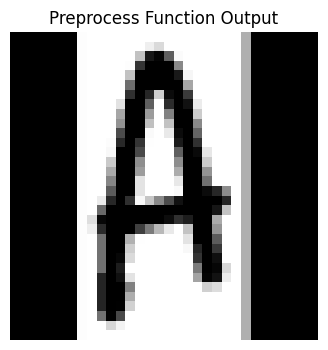

Feature shape: (1024,)


In [24]:
img = cv2.imread("dataset/writer1/A/A_004.png")
norm2 = preprocess_char(img, out_size=32)
show(norm2, title="Preprocess Function Output")

feature_vector2 = norm2.flatten().astype(np.float32) / 255.0
print("Feature shape:", feature_vector2.shape)